In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import os, glob, sys, io
import pathlib

from pprint import pprint
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy
import scipy.signal
import scipy.interpolate

import pickle, yaml
from tqdm.auto import tqdm, trange

from IPython.core.display import display, HTML, Image
print(tf.__version__)

2.3.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4587277212933010529
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15671819224980982425
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5551115836799192328
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
with open("dataset-info.yaml", "r") as datasetInfoFile:
    try:
        info = yaml.safe_load(datasetInfoFile)
    except yaml.YAMLError as exc:
        print(exc)
        
        
pickle_batch_root = info['pickle_batch_root']
batch_size = info['batchsize']
maskSize = info['maxsize']
data_root = os.path.join(pickle_batch_root, str(batch_size))
info

{'maxsize': {'Nx': 384, 'Ny': 616},
 'batchsize': 64,
 'pickle_batch_root': 'F:/MohammadRaziei/project/Dataset/pickle_batch_root'}

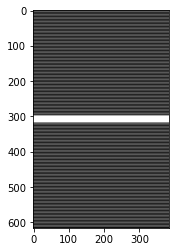

In [4]:
mask_k = np.zeros((maskSize['Ny'], maskSize['Nx']))
mask_k[::4,:] = 1

w = 10;
mask_w = np.zeros((maskSize['Ny'], maskSize['Nx']))
mask_w[maskSize['Ny']//2-w:maskSize['Ny']//2+w,:] = 1

mask_t = np.logical_or(mask_k, mask_w)

plt.imshow(mask_t, cmap='gray')#,interpolation='none')
plt.show()

In [5]:
class KSpaceCatGenerator(tf.keras.utils.Sequence):
    def __init__(self, mask, axis, filenames=None, pickle_root_dir=None, batch_size=None, data_format="channels_first"):
        if filenames:
            self.filenames = filenames
        elif pickle_root_dir:
            self.filenames = glob.glob(pickle_root_dir+"/*.pickle")
        else:
            raise Exception("Error: give me filenames")
        self.mask = mask
        self.axis = axis
        assert(data_format in ["channels_first", "channels_last"])
        self.data_format = data_format
        if pickle_root_dir:
            self.batch_size = self.int(pathlib.Path(self.pickle_root_dir).stem)
        else:
            self.batch_size = batch_size 
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        return self.getitem(index)
        
    def getitem(self, index):
        with open(self.filenames[index], 'rb') as f:
            padded = pickle.load(f)
        inp = padded*self.mask
        out1 = padded
        if self.data_format =="channels_last":
            inp = inp.transpose([0,2,3,1])
            out1 = out1.transpose([0,2,3,1])        
        inp = self.to_float(inp, self.axis)
        out1 = self.to_float(out1, self.axis)
        return inp, out1
    
    @staticmethod
    def to_float(X, axis):
        return np.concatenate([X.real, X.imag], axis=axis)
    @staticmethod
    def to_complex(X, axis):
        ax = np.mod(axis, 4)
        n = X.shape[ax] // 2
        if   ax == 0: a = X[:n,:,:,:] + 1j * X[n:,:,:,:]
        elif ax == 1: a = X[:,:n,:,:] + 1j * X[:,n:,:,:]
        elif ax == 2: a = X[:,:,:n,:] + 1j * X[:,:,n:,:]
        elif ax == 3: a = X[:,:,:,:n] + 1j * X[:,:,:,n:]
        else: raise Exception("not suported axis")
        return a
        
    def transform_to_image_coils(self, data):
        axes = (-2,-1) if self.data_format == "channels_first" else (1,2)
        return np.fft.fftshift(scipy.fft.ifft2(self.to_complex(data, self.axis), axes=axes,
                                              workers=os.cpu_count()))
    def combine_coil_images(self, im):
        return np.sqrt(np.sum(im**2,1 if self.data_format == "channels_first" else 3))
    def transform_to_images(self, data):
        return self.combine_coil_images(self.transform_to_image_coils(data))
   


In [6]:
cat_axis = -1;
data_format = "channels_last"
filenames = glob.glob(data_root+"/*.pickle")
kspacegen = KSpaceCatGenerator(mask_t, axis=cat_axis, filenames=filenames,
                               batch_size=batch_size, data_format=data_format)
print(len(kspacegen))
print(kspacegen.batch_size)
print(kspacegen.data_format)

28
64
channels_last


In [7]:
%time X,Y = kspacegen[0] 
batch_shape = Y.shape
batch_shape

Wall time: 17.8 s


(64, 616, 384, 30)

Wall time: 7.15 s


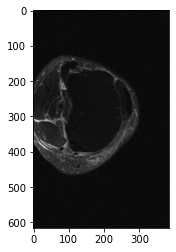

Wall time: 7.32 s


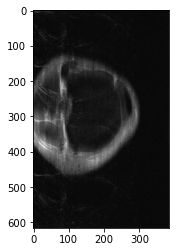

In [8]:
%time images = kspacegen.transform_to_images(Y)
plt.imshow(np.abs(images[5]), cmap='gray')
plt.show()
%time images_alias = kspacegen.transform_to_images(X)
plt.imshow(np.abs(images_alias[5]), cmap='gray')
plt.show()

In [9]:
layer_shape = lambda x: np.asarray(x.shape[1:].as_list())
half_size = lambda x: np.asarray([int(np.floor(x/2)), int(np.ceil(x/2))])
calc_cropping_or_padding = lambda x: np.asarray([half_size(np.abs(x[0])), half_size(np.abs(x[1]))])

In [10]:
class AutoEncoderModel(tf.keras.Model):
    def __init__(self, batch_shape, **kwargs):
        super().__init__(**kwargs, name="AutoEncoderModel")
        # Encoding
        self.num_channel = batch_shape[-1]
        input_layer = layers.Input(shape=batch_shape[1:]) 
        encoding_conv_layer_1 = layers.Conv2D(16, (3, 3), activation='relu', 
                                       padding='same')(input_layer)
        encoding_pooling_layer_1 = layers.MaxPooling2D((2, 2), 
                  
                                     padding='same')(encoding_conv_layer_1)
        encoding_conv_layer_2 = layers.Conv2D(8, (3, 3), activation='relu', 
                                     padding='same')(encoding_pooling_layer_1)
        encoding_pooling_layer_2 = layers.MaxPooling2D((2, 2), 
                                     padding='same')(encoding_conv_layer_2)
        encoding_conv_layer_3 = layers.Conv2D(8, (3, 3), activation='relu', 
                                     padding='same')(encoding_pooling_layer_2)
        code_layer = layers.MaxPooling2D((2, 2), padding='same')(encoding_conv_layer_3)
        
        # Decoding
        decodging_conv_layer_1 = layers.Conv2D(8, (3, 3), activation='relu', 
                                      padding='same')(code_layer)
        decodging_upsampling_layer_1 = layers.UpSampling2D((2, 2))(decodging_conv_layer_1)
        decodging_conv_layer_2 = layers.Conv2D(8, (3, 3), activation='relu', 
                                      padding='same')(decodging_upsampling_layer_1)
        decodging_upsampling_layer_2 = layers.UpSampling2D((2, 2))(decodging_conv_layer_2)
        decodging_conv_layer_3 = layers.Conv2D(16, (3, 3),                      
                                   activation='relu')(decodging_upsampling_layer_2)
        decodging_upsampling_layer_3 = layers.UpSampling2D((2, 2))(decodging_conv_layer_3)
        output = layers.Conv2D(self.num_channel, (3, 3), activation='sigmoid', 
                                      padding='same')(decodging_upsampling_layer_3)
        
        padding = calc_cropping_or_padding((layer_shape(output)-layer_shape(input_layer))[:-1])
        output_layer = layers.ZeroPadding2D(padding)(output)


        self._model = tf.keras.models.Model(input_layer, output_layer, name="_AutoEncoderModel")
    def call(self, inputs):
        return self._model(inputs)
    def plot(self):
        filename = "%s.png"%(self.name)
        tf.keras.utils.plot_model(self._model, filename, True)
        display(Image(filename))
    def summary(self):
        self._model.summary() 

In [11]:
ae = AutoEncoderModel(batch_shape)

In [20]:
ae.name

'AutoEncoderModel'

In [21]:
ae.summary()

Model: "_AutoEncoderModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 616, 384, 30)]    0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 616, 384, 16)      4336      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 308, 192, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 308, 192, 8)       1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 154, 96, 8)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 154, 96, 8)        584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 77, 48, 8)   

In [22]:
%time ae(X).shape

Wall time: 8 s


TensorShape([64, 616, 384, 30])

In [12]:
ae.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
%%time
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

# log_file = 'H-log.csv'
# if os.path.exists(log_file): os.remove(log_file)

# loss_dict = dict(loss={'output': 'categorical_crossentropy', 'Features':'mse'})
# optimizer = tf.keras.optimizers.Adam() #learning_rate=5e-3,beta_1=0.8, beta_2=0.9)
# model.compile( **loss_dict, optimizer=optimizer , metrics={'output': ['accuracy']}, 
#              loss_weights = {'output': 1, 'Features': 50})
history = ae.fit(kspacegen, #steps_per_epoch=len(training_generator),
                    epochs=3,
                    validation_data=None, #validation_steps=len(validation_generator),
                    verbose=0, 
                    callbacks=[
                        tqdm_callback,
                        tf.keras.callbacks.ModelCheckpoint('model-final.h5', monitor='val_loss',
                                                           verbose=0, save_best_only=True, mode='min'),#, save_weights_only=True),
#                         tf.keras.callbacks.ModelCheckpoint('H-model-final_loss.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min'),#, save_weights_only=True),
#                         tf.keras.callbacks.ModelCheckpoint('H-model-final_acc.h5', monitor='val_output_accuracy', verbose=0, save_best_only=True, mode='max'),#, save_weights_only=True),
#                         tf.keras.callbacks.CSVLogger(log_file, append=True, separator=';'),                   
                    ]
                   )

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Training:   0%|                                                                                 0/3 ETA: ?s,  …

Epoch 1/3


0/28                                                                                                         E…

In [92]:
input_layer = Input(shape=(616, 384, 15)) 
encoding_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', 
                           padding='same')(input_layer)
encoding_pooling_layer_1 = MaxPooling2D((2, 2), 

                         padding='same')(encoding_conv_layer_1)
encoding_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', 
                         padding='same')(encoding_pooling_layer_1)
encoding_pooling_layer_2 = MaxPooling2D((2, 2), 
                         padding='same')(encoding_conv_layer_2)
encoding_conv_layer_3 = Conv2D(8, (3, 3), activation='relu', 
                         padding='same')(encoding_pooling_layer_2)
code_layer = MaxPooling2D((2, 2), padding='same')(encoding_conv_layer_3)

# Decoding
decodging_conv_layer_1 = Conv2D(8, (3, 3), activation='relu', 
                          padding='same')(code_layer)
decodging_upsampling_layer_1 = UpSampling2D((2, 2))(decodging_conv_layer_1)
decodging_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', 
                          padding='same')(decodging_upsampling_layer_1)
decodging_upsampling_layer_2 = UpSampling2D((2, 2))(decodging_conv_layer_2)
decodging_conv_layer_3 = Conv2D(16, (3, 3),                      
                       activation='relu')(decodging_upsampling_layer_2)
decodging_upsampling_layer_3 = UpSampling2D((2, 2))(decodging_conv_layer_3)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', 
                          padding='same')(decodging_upsampling_layer_3)

model = Model(input_layer, output_layer)

In [94]:
a = model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 616, 384, 15)]    0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 616, 384, 16)      2176      
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 308, 192, 16)      0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 308, 192, 8)       1160      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 154, 96, 8)        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 154, 96, 8)        584       
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 77, 48, 8)       

In [98]:
a

In [37]:
batch_shape

(64, 616, 384, 30)

In [214]:
layer_shape = lambda x: np.asarray(x.shape[1:].as_list())
half_size = lambda x: np.asarray([int(np.floor(x/2)), int(np.ceil(x/2))])
calc_cropping = lambda x: np.asarray([half_size(np.abs(x[0])), half_size(np.abs(x[1]))])
# cropping_size = calc_cropping((layer_shape(c10) - layer_shape(t01))[0:2])


In [ ]:
# declaring the input layer
# In the original paper the network consisted of only one channel.
inputs = layers.Input(shape=(616,348,15))
# first part of the U - contracting part
c0 = layers.Conv2D(64, activation='relu', kernel_size=3)(inputs)
c1 = layers.Conv2D(64, activation='relu', kernel_size=3)(c0)  # This layer for concatenating in the expansive part
c2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)

c3 = layers.Conv2D(128, activation='relu', kernel_size=3)(c2)
c4 = layers.Conv2D(128, activation='relu', kernel_size=3)(c3)  # This layer for concatenating in the expansive part
c5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c4)

c6 = layers.Conv2D(256, activation='relu', kernel_size=3)(c5)
c7 = layers.Conv2D(256, activation='relu', kernel_size=3)(c6)  # This layer for concatenating in the expansive part
c8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c7)

c9 = layers.Conv2D(512, activation='relu', kernel_size=3)(c8)
c10 = layers.Conv2D(512, activation='relu', kernel_size=3)(c9)  # This layer for concatenating in the expansive part
c11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c10)

c12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(c11)
c13 = layers.Conv2D(1024, activation='relu', kernel_size=3, padding='valid')(c12)

# We will now start the second part of the U - expansive part
t01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c13)
crop01 = layers.Cropping2D(cropping=(4, 4))(c10)

cropping_size = calc_cropping((layer_shape(c10) - layer_shape(t01))[0:2])
crop01 = layers.Cropping2D(cropping=cropping_size)(c10)

concat01 = layers.concatenate([t01, crop01], axis=-1)

c14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
c15 = layers.Conv2D(512, activation='relu', kernel_size=3)(c14)

t02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(c15)
crop02 = layers.Cropping2D(cropping=(16, 16))(c7)

concat02 = layers.concatenate([t02, crop02], axis=-1)

c16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
c17 = layers.Conv2D(256, activation='relu', kernel_size=3)(c16)

t03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(c17)
crop03 = layers.Cropping2D(cropping=(40, 40))(c4)

concat03 = layers.concatenate([t03, crop03], axis=-1)

c18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
c19 = layers.Conv2D(128, activation='relu', kernel_size=3)(c18)

t04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(c19)
crop04 = layers.Cropping2D(cropping=(88, 88))(c1)

concat04 = layers.concatenate([t04, crop04], axis=-1)

c20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
c21 = layers.Conv2D(64, activation='relu', kernel_size=3)(c20)

outputs = layers.Conv2D(2, kernel_size=1)(c21)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

In [20]:
# declaring the input layer
# In the original paper the network consisted of only one channel.
inputs = layers.Input(shape=(616,348,15))
# first part of the U - contracting part
c0 = layers.Conv2D(64, activation='relu', kernel_size=3)(inputs)
c1 = layers.Conv2D(64, activation='relu', kernel_size=3)(c0)  # This layer for concatenating in the expansive part
c2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)

c3 = layers.Conv2D(128, activation='relu', kernel_size=3)(c2)
c4 = layers.Conv2D(128, activation='relu', kernel_size=3)(c3)  # This layer for concatenating in the expansive part
c5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c4)

c6 = layers.Conv2D(256, activation='relu', kernel_size=3)(c5)
c7 = layers.Conv2D(256, activation='relu', kernel_size=3)(c6)  # This layer for concatenating in the expansive part
c8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c7)

c9 = layers.Conv2D(512, activation='relu', kernel_size=3)(c8)
c10 = layers.Conv2D(512, activation='relu', kernel_size=3)(c9)  # This layer for concatenating in the expansive part
c11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c10)

c12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(c11)
c13 = layers.Conv2D(1024, activation='relu', kernel_size=3, padding='valid')(c12)

# We will now start the second part of the U - expansive part
t04 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c13)
crop04 = layers.Cropping2D(cropping=((5,4), (4,4)))(c10)

concat04 = layers.concatenate([t04, crop04], axis=-1)

c20 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(concat04)
c21 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c20)
c22 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c21)
c23 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c22)


outputs = layers.Conv2D(2, kernel_size=1)(c23)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")
outputs

<tf.Tensor 'conv2d_97/BiasAdd:0' shape=(None, 960, 448, 2) dtype=float32>

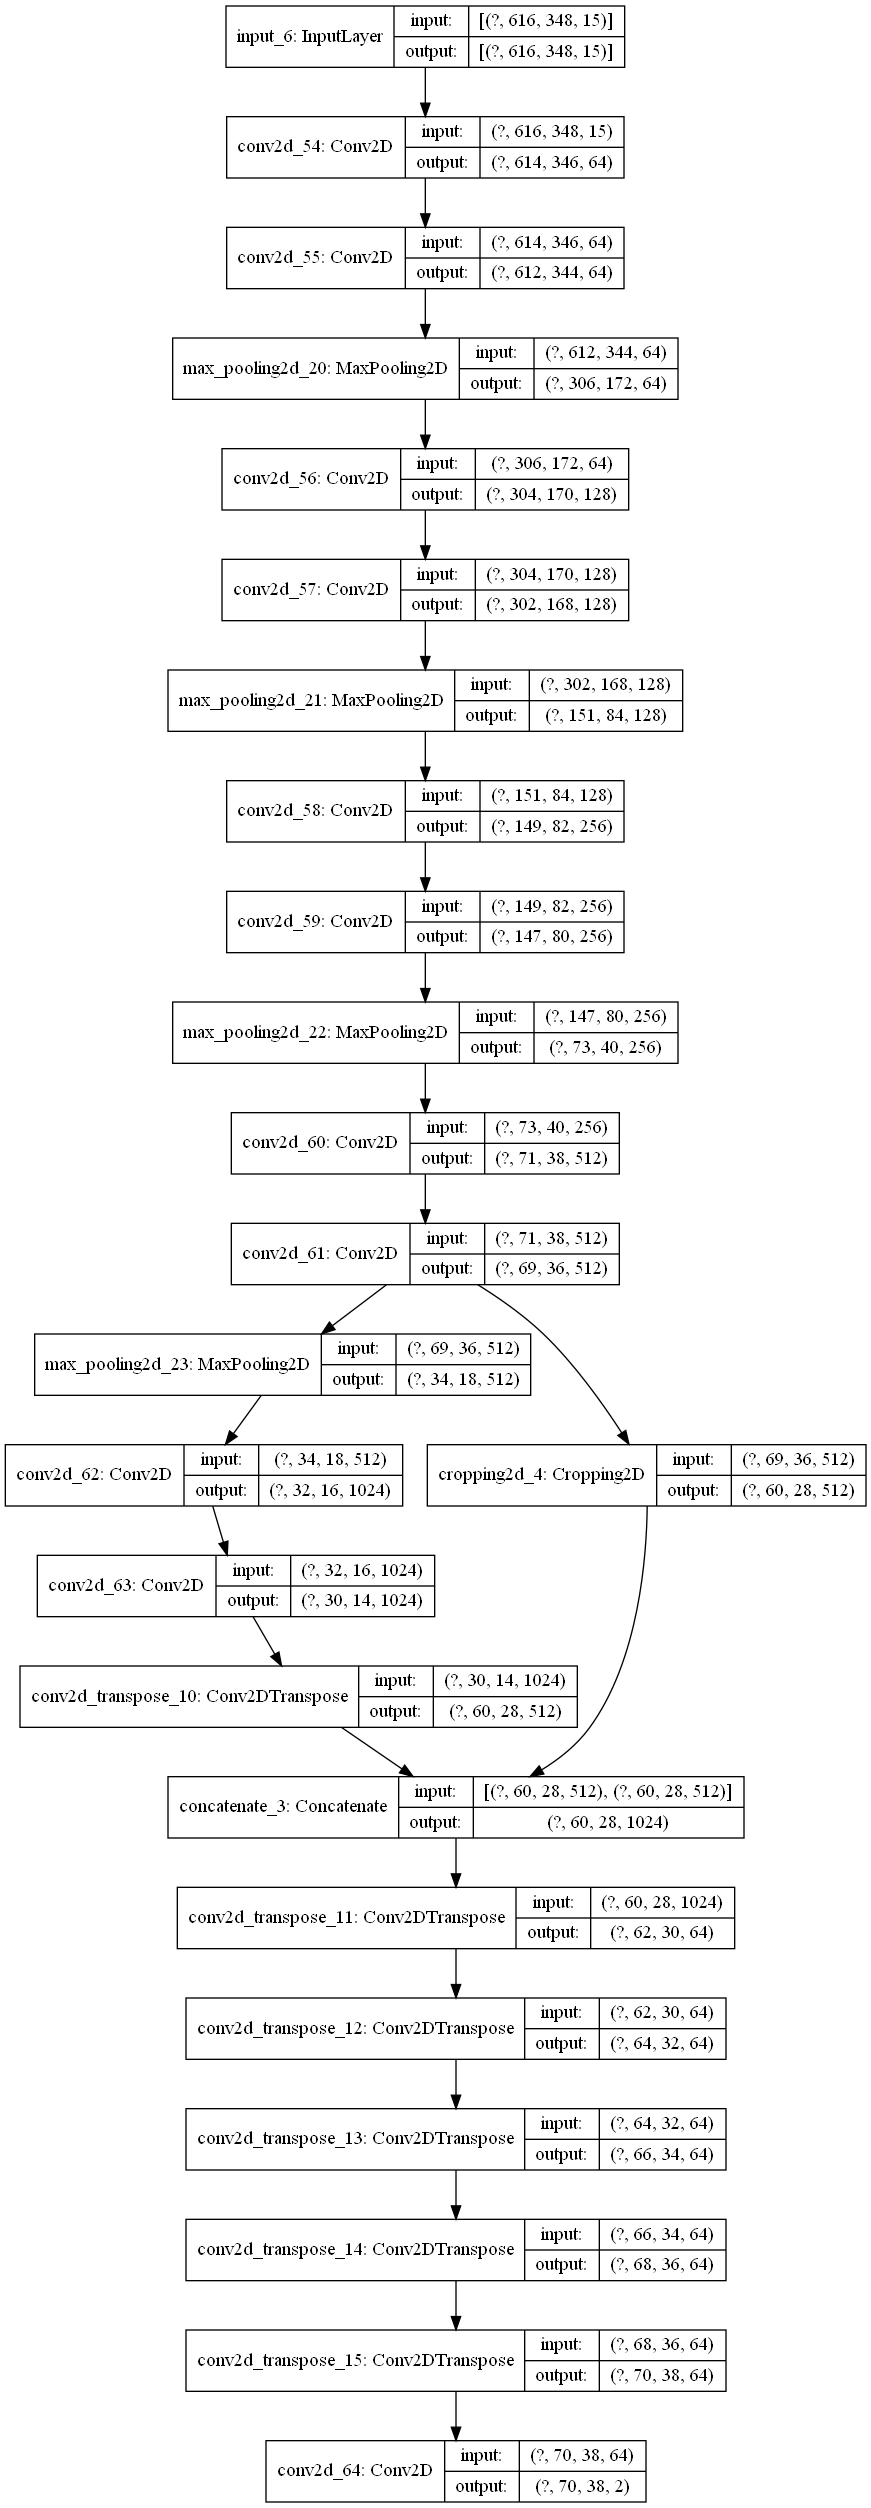

In [17]:
tf.keras.utils.plot_model(model, "unet.png", True)

In [248]:
cropping_size

array([[98, 98],
       [92, 92]])

In [222]:
c7.shape

TensorShape([None, 147, 80, 256])

In [183]:
c11.shape

TensorShape([None, 34, 18, 512])

In [223]:
a = layer_shape(c7) - layer_shape(t02)
a

array([35, 32,  0])

array([[4, 5],
       [4, 4]])

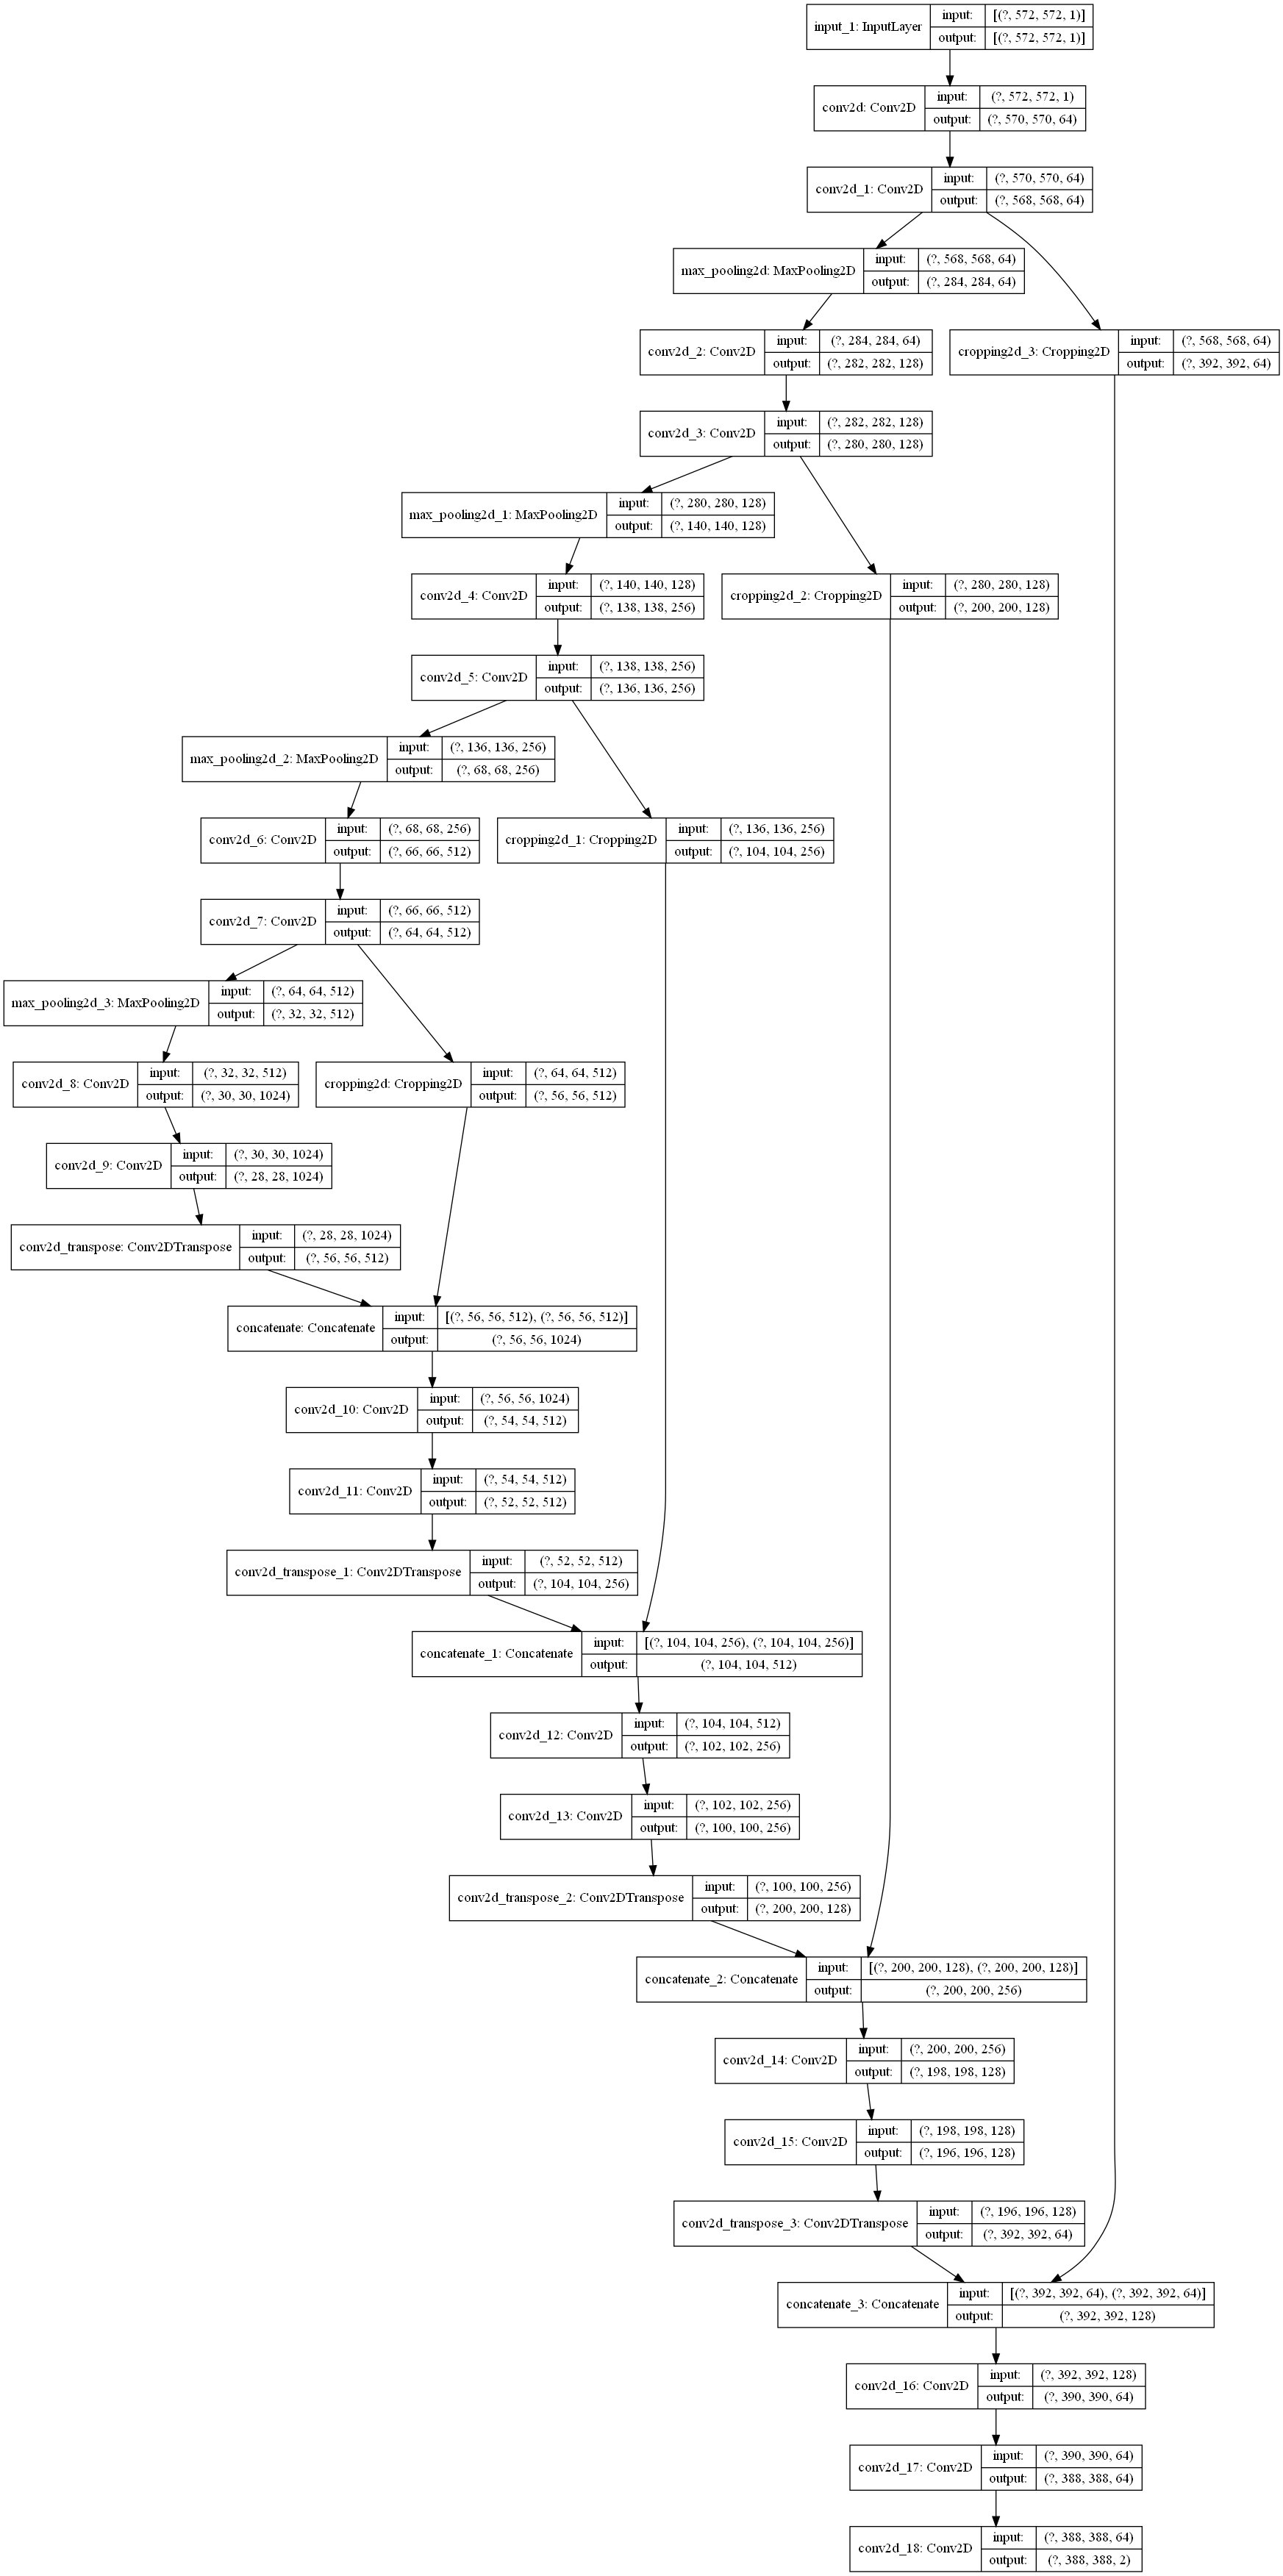

In [3]:
tf.keras.utils.plot_model(model, "unet.png", True)